# Graph Machine Learning
## Node Classification

PubMed: it is an even bigger dataset with 19717 scientific publications about diabetes from PubMed’s database, classified into 3 categories.

*  Diabetes Mellitus Experimental
*  Diabetes Mellitus Type_1
*  Diabetes Mellitus Type_2

The citation network consists of 44,338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

Objective
The goal is to classify each publication into one of the three classes by performing Node classification using GCN, GraphSAGE, and GAT.

In [30]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

We import the necessary libraries to create our own GAT class, using the GATv2 layer:

In [31]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv, SAGEConv
from torch.nn import Linear, Dropout
from torch_geometric.utils import degree
from collections import Counter

import numpy as np
import pandas as pd

# Dataset
from torch_geometric.datasets import Planetoid

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

We implement the `accuracy()` function to evaluate the performance of our model:

In [32]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

### Load dataset

In [33]:
dataset = Planetoid(root='.', name='PubMed')
data = dataset[0]  # Get the first graph object.

# view the dataset details
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

print(data)

Dataset: PubMed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [ ]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


### Visualizing Graph

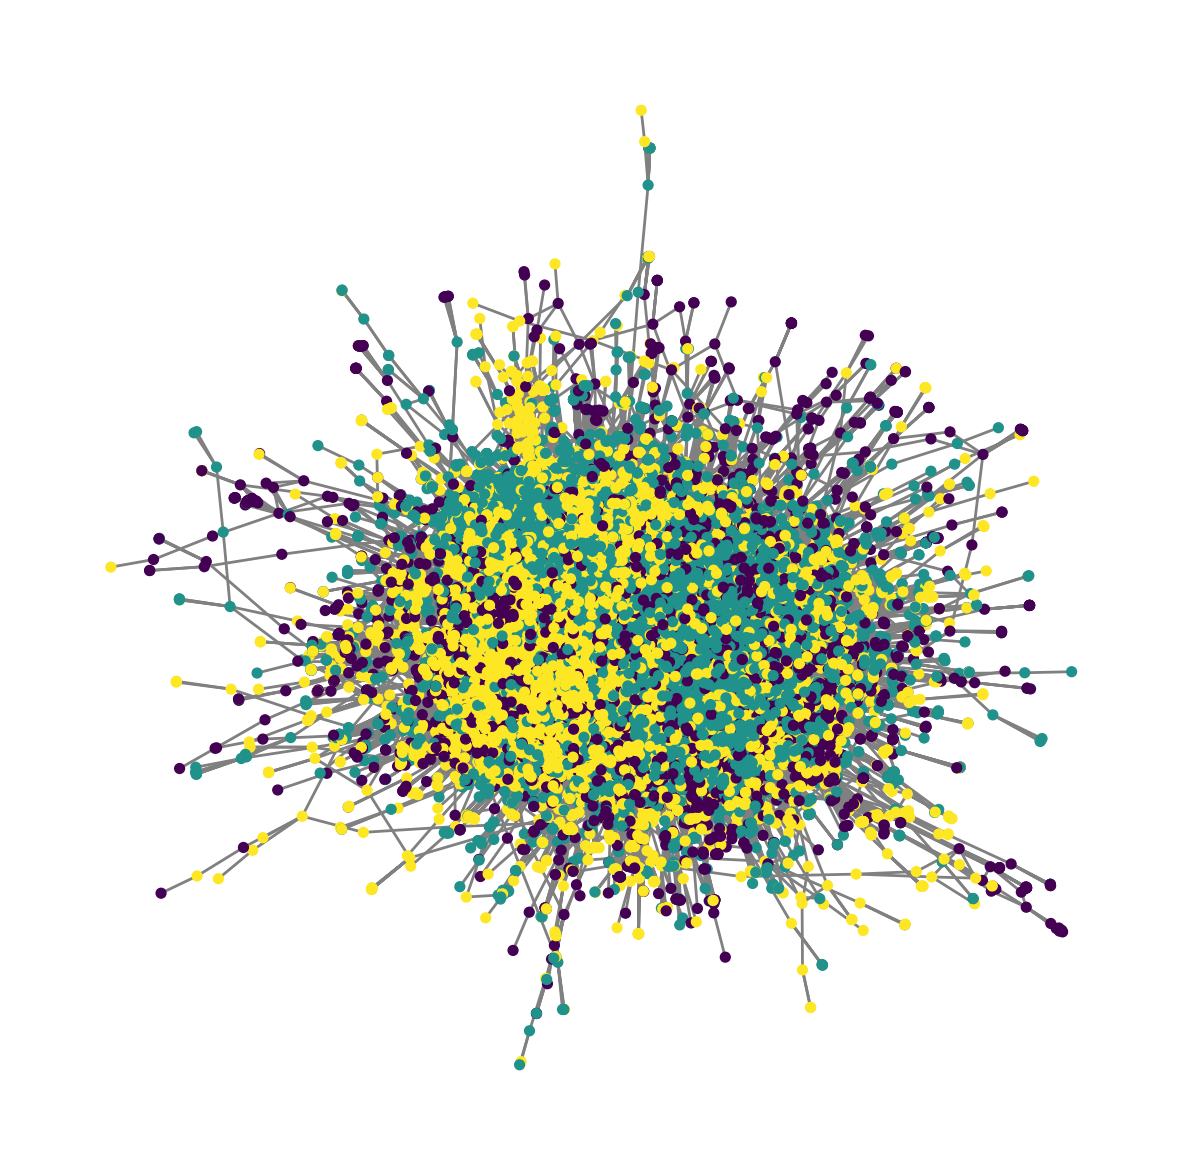

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(15,15))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

In [ ]:
print(f"""

Propiedades globales del grafo
==============================

        - Degree medio: Número de conexiones medio de los nodos de un grafo.
                {((G.number_of_edges()*2) / G.number_of_nodes()):,.3}
        - Densidad del grafo: Número de conexiones / Número posible de conexiones.
                {nx.density(G)}
        - Otras medidas: Transitividad, Reciprocidad.
                {nx.transitivity(G)}
                {nx.algorithms.clustering(G)}

"""
)



Propiedades globales del grafo

        - Degree medio: Número de conexiones medio de los nodos de un grafo.
                4.5
        - Densidad del grafo: Número de conexiones / Número posible de conexiones.
                0.00022803908825811382
        - Otras medidas: Transitividad, Reciprocidad.
                0.0537076280274887
                {0: 0.3, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.13852813852813853, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0.044444444444444446, 13: 0, 14: 0, 15: 0.3333333333333333, 16: 0, 17: 0, 18: 0.35714285714285715, 19: 0, 20: 0, 21: 0, 22: 1.0, 23: 0, 24: 0.16666666666666666, 25: 0, 26: 0.1, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0.6666666666666666, 35: 0.007352941176470588, 36: 0, 37: 0, 38: 0.5, 39: 0, 40: 0.14285714285714285, 41: 0.16666666666666666, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0.023655913978494623, 48: 0.12418300653594772, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0.3333333333333333, 55: 1.0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0

In [ ]:
print("Número de nodos:", G.number_of_nodes())
print("Número de enlaces:", G.number_of_edges())

Número de nodos: 19717
Número de enlaces: 44324


For good measure, we plot the number of nodes per node degree...

<BarContainer object of 82 artists>

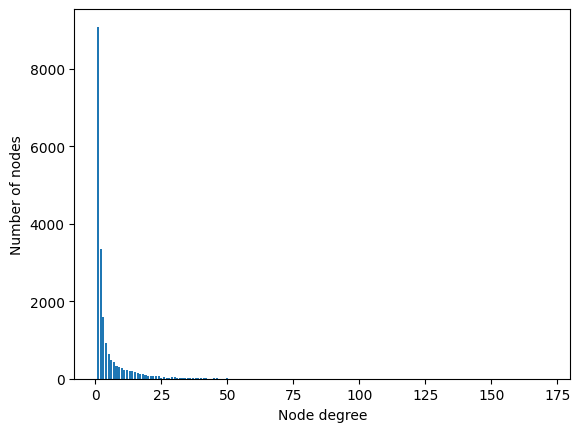

In [ ]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

## Build GNN (Graph Neural Network) models

In [34]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

In [35]:
def test(model, data, MLP=False):
    model.eval()
    if MLP:
      out = model(data.x)
    else:
      _, out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
    return test_acc

In [36]:
import plotly.graph_objects as go

def history_plot(history, plot_name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=history['epoch'], y=history['loss'], mode='lines', name='Training Loss'))
    fig.add_trace(go.Scatter(x=history['epoch'], y=history['test_acc'], mode='lines', name='Validation Accuracy'))
    fig.update_layout(
        title='Training History',
        xaxis_title='Epoch',
        yaxis_title='Value',
        legend=dict(x=0, y=1),
        template='plotly_dark'
    )
    fig.show()

In [37]:
def train(model, data, epochs=10, plot=True, plot_name = "plot", MLP=False):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    history = {
            'epoch': [],
            'loss': [],
            'test_acc': [],
            'outputs' : []
    }

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        if MLP:
          out = model(data.x)
        else:
          _, out = model(data.x, data.edge_index)

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['test_acc'].append(val_acc)
        history['outputs'].append(out[data.train_mask].argmax(dim=1))

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    if plot:
        history_plot(history, plot_name)

    return model

### Build MLP

In [38]:
class MLP(torch.nn.Module):
    def __init__(self, dim_input, hidden_channels, dim_output):
        super(MLP, self).__init__()
        self.lin1 = Linear(dim_input, hidden_channels)
        self.lin2 = Linear(hidden_channels, dim_output)
        self.dropout = 0.5
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [41]:
%%time
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
train(model=mlp, data=data, epochs=100, MLP=True)
acc = test(model=mlp, data=data, MLP=True)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.099 | Train Acc:  38.33% | Val Loss: 1.12 | Val Acc: 25.00%
Epoch  10 | Train Loss: 1.022 | Train Acc:  75.00% | Val Loss: 1.06 | Val Acc: 57.80%
Epoch  20 | Train Loss: 0.873 | Train Acc:  81.67% | Val Loss: 0.99 | Val Acc: 56.40%
Epoch  30 | Train Loss: 0.566 | Train Acc:  90.00% | Val Loss: 0.91 | Val Acc: 58.20%
Epoch  40 | Train Loss: 0.404 | Train Acc:  91.67% | Val Loss: 0.87 | Val Acc: 59.60%
Epoch  50 | Train Loss: 0.276 | Train Acc:  93.33% | Val Loss: 0.94 | Val Acc: 57.80%
Epoch  60 | Train Loss: 0.272 | Train Acc:  93.33% | Val Loss: 0.91 | Val Acc: 59.00%
Epoch  70 | Train Loss: 0.165 | Train Acc:  98.33% | Val Loss: 0.95 | Val Acc: 59.80%
Epoch  80 | Train Loss: 0.205 | Train Acc:  96.67% | Val Loss: 0.96 | Val Acc: 60.00%
Epoch  90 | Train Loss: 0.174 | Train Acc:  95.00% | Val Loss: 0.98 | Val Acc: 57.20%
Epoch 100 | Train Loss: 0.185 | Train Acc:  95.00% | Val Loss: 0.93 | Val Acc: 62.20%



MLP test accuracy: 72.40%

CPU times: user 8.81 s, sys: 10.3 s, total: 19.1 s
Wall time: 38.2 s


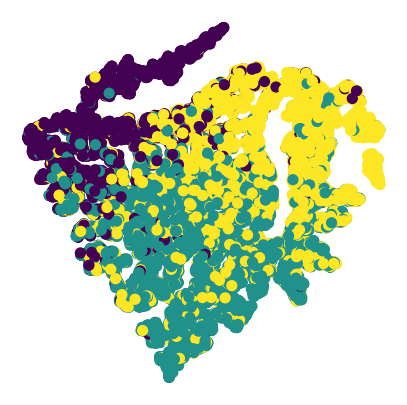

In [47]:
h = mlp(data.x)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

### Build GCN (Graph Convolutional Network) model

In [48]:
class GCN(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output):
      super().__init__()
      self.conv1 = GCNConv(dim_input, dim_hidden)
      self.conv2 = GCNConv(dim_hidden, dim_output)
      self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
      x = self.conv1(x, edge_index)
      x = x.relu()
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.conv2(x, edge_index)
      return x, F.log_softmax(x, dim=1)

In [49]:
%%time
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
train(gcn, data, 100)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.099 | Train Acc:  33.33% | Val Loss: 1.10 | Val Acc: 36.40%
Epoch  10 | Train Loss: 0.917 | Train Acc:  86.67% | Val Loss: 0.99 | Val Acc: 69.80%
Epoch  20 | Train Loss: 0.702 | Train Acc:  88.33% | Val Loss: 0.85 | Val Acc: 71.60%
Epoch  30 | Train Loss: 0.489 | Train Acc:  95.00% | Val Loss: 0.76 | Val Acc: 72.00%
Epoch  40 | Train Loss: 0.344 | Train Acc:  93.33% | Val Loss: 0.68 | Val Acc: 74.00%
Epoch  50 | Train Loss: 0.235 | Train Acc:  98.33% | Val Loss: 0.63 | Val Acc: 73.40%
Epoch  60 | Train Loss: 0.184 | Train Acc:  98.33% | Val Loss: 0.61 | Val Acc: 76.40%
Epoch  70 | Train Loss: 0.136 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 75.40%
Epoch  80 | Train Loss: 0.143 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 74.60%
Epoch  90 | Train Loss: 0.145 | Train Acc:  98.33% | Val Loss: 0.65 | Val Acc: 73.60%
Epoch 100 | Train Loss: 0.111 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 74.40%



GCN test accuracy: 78.60%

CPU times: user 7 s, sys: 17.4 ms, total: 7.01 s
Wall time: 7.03 s


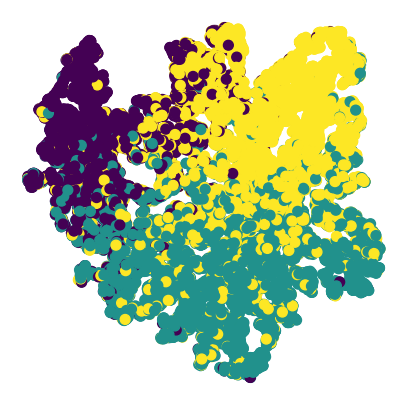

In [50]:
h, _ = gcn(data.x, data.edge_index)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

### Build GAT model

In [51]:
class GAT(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output, heads=8, lr=0.01, weight_decay=5e-4):
    super().__init__()
    self.gat1 = GATv2Conv(dim_input, dim_hidden, heads=heads)
    self.gat2 = GATv2Conv(dim_hidden*heads, dim_output, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

  def forward(self, x, edge_index):
    x = self.gat1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.gat2(x, edge_index)
    return x, F.log_softmax(x, dim=1)

In [52]:
%%time
gat = GAT(dataset.num_features, 16, dataset.num_classes)
train(gat, data, 100)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.094 | Train Acc:  40.00% | Val Loss: 1.09 | Val Acc: 41.00%
Epoch  10 | Train Loss: 0.522 | Train Acc:  95.00% | Val Loss: 0.75 | Val Acc: 74.80%
Epoch  20 | Train Loss: 0.184 | Train Acc:  95.00% | Val Loss: 0.60 | Val Acc: 76.20%
Epoch  30 | Train Loss: 0.073 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 76.40%
Epoch  40 | Train Loss: 0.043 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 77.40%
Epoch  50 | Train Loss: 0.051 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 74.00%
Epoch  60 | Train Loss: 0.043 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 76.20%
Epoch  70 | Train Loss: 0.048 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 74.20%
Epoch  80 | Train Loss: 0.027 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 75.40%
Epoch  90 | Train Loss: 0.035 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 74.00%
Epoch 100 | Train Loss: 0.029 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 75.80%



GAT test accuracy: 76.80%

CPU times: user 1min, sys: 43.8 s, total: 1min 44s
Wall time: 1min 44s


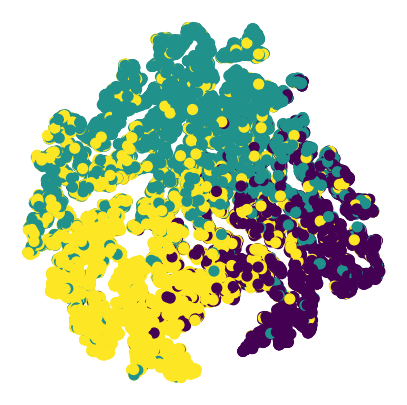

In [54]:
h, _ = gat(data.x, data.edge_index)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

Los nodos que pertenecen a las mismas clases se agrupan. Podemos ver tres grupos, correspondientes a las tres clases de cáncer.

### Build GraphSAGE

In [ ]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(10,10))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

Creamos cuatro subgrafos de varios tamaños. Nos permite procesarlos en paralelo y es más fácil procesarlos.

In [ ]:
from torch_geometric.utils import degree
from collections import Counter
import seaborn as sns
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def plot_degree(data, index, title):
    # Obtener lista de grados para cada nodo
    degrees = degree(data.edge_index[index]).numpy()
    # Contar el número de nodos para cada grado
    numbers = Counter(degrees)
    # Convertir los datos a un DataFrame de pandas
    degree_df = pd.DataFrame.from_dict(numbers, orient='index').reset_index()
    degree_df.columns = ['Degree', 'Count']
    sns.barplot(ax=axes[index], x='Degree', y='Count', data=degree_df)
    axes[index].set_xlabel('Node Degree')
    axes[index].set_ylabel('Number of Nodes')
    axes[index].set_title(title)
    axes[index].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axes[index].tick_params(axis='x', labelsize=8)
    axes[index].tick_params(axis='y', labelsize=10)
    axes[index].set_xticks(range(len(degree_df)))
    axes[index].set_xticklabels(axes[index].get_xticklabels(), rotation=90)

plot_degree(data,0,'Plot node degrees from the original graph')
plot_degree(subdata,1,'Plot node degrees from the last subgraph')

El primer gráfico muestra la distribución original de los grados de los nodos, mientras que el segundo muestra la distribución obtenida después del muestreo de vecinos. En este ejemplo, elegimos considerar solo cinco vecinos, que es mucho menor que el valor máximo original. Es importante recordar este compromiso al hablar sobre GraphSAGE.

PinSAGE propone otra solución. En lugar de muestreo de vecinos, PinSAGE simula caminatas aleatorias para cada nodo, lo que captura una representación mejor de sus vecindarios. Luego, selecciona un número predefinido de vecinos con el mayor número de visitas. Esta técnica permite a PinSAGE considerar la importancia de cada vecino mientras controla el tamaño del grafo de computación.

In [ ]:
class GraphSAGE(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output):
    super().__init__()
    self.sage1 = SAGEConv(dim_input, dim_hidden)
    self.sage2 = SAGEConv(dim_hidden, dim_output)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

In [ ]:
@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 1000)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.147 | Train Acc:  30.24% | Val Loss: 1.13 | Val Acc: 27.92%
Epoch  10 | Train Loss: 0.101 | Train Acc: 100.00% | Val Loss: 0.69 | Val Acc: 68.69%
Epoch  20 | Train Loss: 0.053 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 70.43%
Epoch  30 | Train Loss: 0.031 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 64.96%
Epoch  40 | Train Loss: 0.023 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 78.19%
Epoch  50 | Train Loss: 0.024 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 80.00%
Epoch  60 | Train Loss: 0.021 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 82.86%
Epoch  70 | Train Loss: 0.020 | Train Acc: 100.00% | Val Loss: 0.34 | Val Acc: 87.63%
Epoch  80 | Train Loss: 0.021 | Train Acc: 100.00% | Val Loss: 0.41 | Val Acc: 85.36%
Epoch  90 | Train Loss: 0.020 | Train Acc: 100.00% | Val Loss: 0.43 | Val Acc: 85.08%
Epoch 100 | Train Loss: 0.019 | Train Acc: 100.00

Con GraphSAGE, recorremos lotes (nuestros cuatro subgrafos) creados por el proceso de muestreo vecino. La forma en que calculamos la precisión y la pérdida de validación también es diferente por eso.

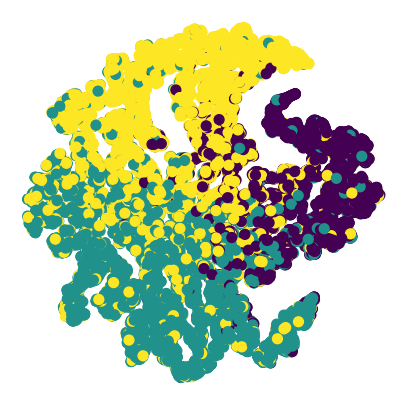

In [ ]:
h = graphsage(data.x, data.edge_index)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()